In [120]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Input, InputLayer, Conv2D, Flatten, Dense, Reshape, Conv2DTranspose
from tqdm import tqdm
import numpy as np

print(tf.executing_eagerly())

mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normaliser les données
train_images = train_images / 255.0
test_images = test_images / 255.0

True


In [148]:
class VAE_Huber_energy:

    def __init__(self, input_dim, latent_dim = 8, encoder = None, decoder = None, optimizer = None):
        self.latent_dim = latent_dim

        if encoder is None:
            self.encoder = tf.keras.Sequential([
                InputLayer(input_shape=input_dim),
                Conv2D(32, (3, 3), activation='relu'),
                Conv2D(64, (3, 3), activation='relu'),
                Flatten(),
                Dense(128, activation='relu'),
                Dense(latent_dim, activation=None)
            ])
        else:
            self.encoder = encoder

        if decoder is None:
            self.decoder = tf.keras.Sequential([
                InputLayer(input_shape=latent_dim),
                Dense(256, activation='relu'),
                Dense(1024, activation='relu'),
                Dense(8*8*8, activation='relu'),
                Reshape((8,8,8)),
                Conv2DTranspose(16, (8, 8), activation='relu'),
                Conv2DTranspose(4, (8, 8), activation='relu'),
                Conv2DTranspose(1, (7, 7)),
            ])
            print(self.decoder.output_shape)
        else:
            self.decoder = decoder

        if optimizer is None:
            self.optimizer = tf.compat.v1.train.AdamOptimizer(
                learning_rate=0.005,
                beta1=0.9,
                beta2=0.999,
                epsilon=1e-08,
                use_locking=False,
                name='Adam'
            )
        else:
            self.optimizer = optimizer

    def RS_distance_to_N01(self, Z):
        Nf = tf.stop_gradient(tf.cast(tf.shape(Z)[0], tf.float32))#batch size as float
        Df = tf.stop_gradient(tf.cast(tf.shape(Z)[1], tf.float32))#dimension as float

        # Term 1: c0 and c1
        f0 = tf.stop_gradient((tf.sqrt(2.)-1.)*tf.exp(tf.math.lgamma(Df/2.0+0.5)-tf.math.lgamma(Df/2.0)))
        ddf0 = tf.stop_gradient(tf.exp(tf.math.lgamma(.5+Df/2.)-tf.math.lgamma(1.+Df/2.))/tf.sqrt(2.))

        c0 = f0 - 1./ddf0
        c1 = 1/(ddf0**2)

        # Term 2
        term2 = tf.reduce_mean(tf.sqrt(tf.square(tf.math.reduce_euclidean_norm(Z, axis=1)) + c1))

        # Term 3
        _1 = tf.tile(tf.expand_dims(Z, 2), [1,1,Nf])
        _2 = tf.transpose(_1, perm = [2,1,0])
        _3 = _1 - _2
        _4 = tf.reduce_sum(tf.square(_3), axis = 1)
        _5 = _4 + tf.eye(Nf)
        eps = 1e-4
        _6 = tf.sqrt(_5 + eps)
        term3 = tf.reduce_mean(_6)/2 + tf.stop_gradient(tf.sqrt(1 + eps)/(2*Nf))

        RS_loss = c0 + term2 - term3
        return RS_loss
        #set diag = 1 because of the singularity of sqrt'(x) in zero. This is a numerical
        #issue due to low precision of the GPU computations; it is compensated
        #exactly in the return value
        #distZZ = tf.matrix_set_diag(distZZ,tf.ones([ tf.stop_gradient(tf.shape(Z)[0]) ]),name=None)

        #smalleps=1e-4
        #return c0+tf.reduce_mean(tf.sqrt(dist_real_Z+c1)) -0.5*tf.reduce_mean(tf.sqrt(distZZ+1e-6))+0.5/Nf+2.*tf.sqrt(smalleps)
        #Note: 0.5/Nf has been added in order to compensate the "1" set on the diagonal
        #if necessary to apply the log in the cost, add a small constant for smoothness near zero

    def train(self, tensor_input_x, epochs = 100, batch_size = 100):
        rng = np.random.default_rng()
        epoch = 0

        for epoch in tqdm(range(epochs)):

            batch = rng.integers(low = 0, high = len(tensor_input_x), size = batch_size)
            batch_input = tensor_input_x[batch]

            with tf.GradientTape() as tape:
                encoded_batch = self.encoder(batch_input)
                decoded_batch = self.decoder(encoded_batch)

                flatten_input = tf.cast(tf.reshape(batch_input, [batch_size, -1]), 'float32')
                flatten_output = tf.reshape(decoded_batch, [batch_size, -1])

                _1 = flatten_input - flatten_output
                _2 = tf.square(_1)
                _3 = tf.reduce_sum(_2, axis=1)

                rec_term = tf.cast(tf.reduce_mean(_3), dtype = 'float32')

                dist_to_N01_term = self.RS_distance_to_N01(encoded_batch)
                lambda_factor = 10.0

                cost_function = rec_term + lambda_factor * dist_to_N01_term

                gradients = tape.gradient(cost_function, self.encoder.trainable_weights + self.decoder.trainable_weights)
                #print(gradients)
                self.optimizer.apply_gradients(zip(gradients, self.encoder.trainable_weights + self.decoder.trainable_weights))

            epoch += 1
            if epoch % 10 == 0:
                print(f"\nEpoch {epoch}, Reconstruction Error: {rec_term.numpy()}, RS Distance: {dist_to_N01_term.numpy()}")

In [149]:
input_dim = train_images.shape
input_im_dim = (input_dim[1], input_dim[2], 1)

latent_dim = 10

decoder = Sequential([
    InputLayer(input_shape=latent_dim),
    Dense(256, activation='relu'),
    Dense(1024, activation='relu'),
    Dense(1024, activation='relu'),
    Dense(28*28, activation='relu'),
    Reshape((1, 28, 28)),
])

model = VAE_Huber_energy(input_im_dim, latent_dim = latent_dim, decoder = decoder)
model.train(train_images, epochs=400, batch_size = 150)

  2%|▎         | 10/400 [00:04<02:55,  2.22it/s]


Epoch 10, Reconstruction Error: 86.56620025634766, RS Distance: 0.8372675180435181


  5%|▌         | 20/400 [00:10<03:11,  1.99it/s]


Epoch 20, Reconstruction Error: 60.437644958496094, RS Distance: 0.8560490608215332


  8%|▊         | 30/400 [00:14<02:49,  2.18it/s]


Epoch 30, Reconstruction Error: 51.58842086791992, RS Distance: 0.8067004680633545


 10%|█         | 40/400 [00:20<03:46,  1.59it/s]


Epoch 40, Reconstruction Error: 54.509490966796875, RS Distance: 0.7085213661193848


 12%|█▎        | 50/400 [00:24<02:38,  2.21it/s]


Epoch 50, Reconstruction Error: 52.4118766784668, RS Distance: 0.5272916555404663


 15%|█▌        | 60/400 [00:29<02:42,  2.09it/s]


Epoch 60, Reconstruction Error: 49.17143630981445, RS Distance: 0.2462712526321411


 18%|█▊        | 70/400 [00:35<02:43,  2.01it/s]


Epoch 70, Reconstruction Error: 43.25686264038086, RS Distance: 0.0929023027420044


 20%|██        | 80/400 [00:39<02:30,  2.12it/s]


Epoch 80, Reconstruction Error: 45.15095520019531, RS Distance: 0.09475946426391602


 22%|██▎       | 90/400 [00:45<03:34,  1.44it/s]


Epoch 90, Reconstruction Error: 41.15303421020508, RS Distance: 0.10652732849121094


 25%|██▌       | 100/400 [00:50<02:19,  2.16it/s]


Epoch 100, Reconstruction Error: 36.18062210083008, RS Distance: 0.0476224422454834


 28%|██▊       | 110/400 [00:54<02:10,  2.23it/s]


Epoch 110, Reconstruction Error: 36.043766021728516, RS Distance: 0.04242753982543945


 30%|███       | 120/400 [01:00<02:17,  2.04it/s]


Epoch 120, Reconstruction Error: 32.7128791809082, RS Distance: 0.03315901756286621


 32%|███▎      | 130/400 [01:05<02:03,  2.18it/s]


Epoch 130, Reconstruction Error: 32.2251091003418, RS Distance: 0.03973817825317383


 35%|███▌      | 140/400 [01:10<02:53,  1.50it/s]


Epoch 140, Reconstruction Error: 29.439247131347656, RS Distance: 0.036834716796875


 38%|███▊      | 150/400 [01:15<01:57,  2.13it/s]


Epoch 150, Reconstruction Error: 28.95450782775879, RS Distance: 0.034265756607055664


 40%|████      | 160/400 [01:19<01:48,  2.22it/s]


Epoch 160, Reconstruction Error: 25.42997169494629, RS Distance: 0.04647994041442871


 42%|████▎     | 170/400 [01:25<01:54,  2.01it/s]


Epoch 170, Reconstruction Error: 25.60295295715332, RS Distance: 0.0235593318939209


 45%|████▌     | 180/400 [01:30<01:41,  2.16it/s]


Epoch 180, Reconstruction Error: 26.822757720947266, RS Distance: 0.026538848876953125


 48%|████▊     | 190/400 [01:35<02:17,  1.53it/s]


Epoch 190, Reconstruction Error: 27.648998260498047, RS Distance: 0.02278757095336914


 50%|█████     | 200/400 [01:40<01:34,  2.13it/s]


Epoch 200, Reconstruction Error: 26.595592498779297, RS Distance: 0.02036261558532715


 52%|█████▎    | 210/400 [01:44<01:25,  2.23it/s]


Epoch 210, Reconstruction Error: 25.11019515991211, RS Distance: 0.020917654037475586


 55%|█████▌    | 220/400 [01:50<01:32,  1.95it/s]


Epoch 220, Reconstruction Error: 25.330827713012695, RS Distance: 0.016563892364501953


 57%|█████▊    | 230/400 [01:55<01:19,  2.15it/s]


Epoch 230, Reconstruction Error: 23.6101131439209, RS Distance: 0.03023052215576172


 60%|██████    | 240/400 [02:00<01:40,  1.59it/s]


Epoch 240, Reconstruction Error: 24.1246395111084, RS Distance: 0.01721334457397461


 62%|██████▎   | 250/400 [02:05<01:10,  2.14it/s]


Epoch 250, Reconstruction Error: 22.686830520629883, RS Distance: 0.023292064666748047


 65%|██████▌   | 260/400 [02:09<01:03,  2.21it/s]


Epoch 260, Reconstruction Error: 24.75246810913086, RS Distance: 0.021250486373901367


 68%|██████▊   | 270/400 [02:15<01:05,  1.99it/s]


Epoch 270, Reconstruction Error: 23.2805233001709, RS Distance: 0.012663841247558594


 70%|███████   | 280/400 [02:20<00:53,  2.26it/s]


Epoch 280, Reconstruction Error: 21.54291534423828, RS Distance: 0.01582026481628418


 72%|███████▎  | 290/400 [02:25<01:07,  1.64it/s]


Epoch 290, Reconstruction Error: 21.733524322509766, RS Distance: 0.027079343795776367


 75%|███████▌  | 300/400 [02:30<00:50,  1.97it/s]


Epoch 300, Reconstruction Error: 23.042829513549805, RS Distance: 0.021956920623779297


 78%|███████▊  | 310/400 [02:34<00:40,  2.22it/s]


Epoch 310, Reconstruction Error: 21.189786911010742, RS Distance: 0.02538323402404785


 80%|████████  | 320/400 [02:40<00:42,  1.88it/s]


Epoch 320, Reconstruction Error: 20.83456802368164, RS Distance: 0.015456199645996094


 82%|████████▎ | 330/400 [02:45<00:31,  2.19it/s]


Epoch 330, Reconstruction Error: 22.795387268066406, RS Distance: 0.014844417572021484


 85%|████████▌ | 340/400 [02:50<00:36,  1.62it/s]


Epoch 340, Reconstruction Error: 22.018695831298828, RS Distance: 0.012759923934936523


 88%|████████▊ | 350/400 [02:55<00:23,  2.09it/s]


Epoch 350, Reconstruction Error: 21.407129287719727, RS Distance: 0.012589454650878906


 90%|█████████ | 360/400 [03:00<00:18,  2.17it/s]


Epoch 360, Reconstruction Error: 20.68523597717285, RS Distance: 0.011301755905151367


 92%|█████████▎| 370/400 [03:05<00:16,  1.86it/s]


Epoch 370, Reconstruction Error: 20.027860641479492, RS Distance: 0.013683319091796875


 95%|█████████▌| 380/400 [03:10<00:10,  1.98it/s]


Epoch 380, Reconstruction Error: 20.779170989990234, RS Distance: 0.012412548065185547


 98%|█████████▊| 390/400 [03:15<00:06,  1.59it/s]


Epoch 390, Reconstruction Error: 20.7795352935791, RS Distance: 0.006392717361450195


100%|██████████| 400/400 [03:20<00:00,  1.99it/s]


Epoch 400, Reconstruction Error: 20.566083908081055, RS Distance: 0.007702350616455078


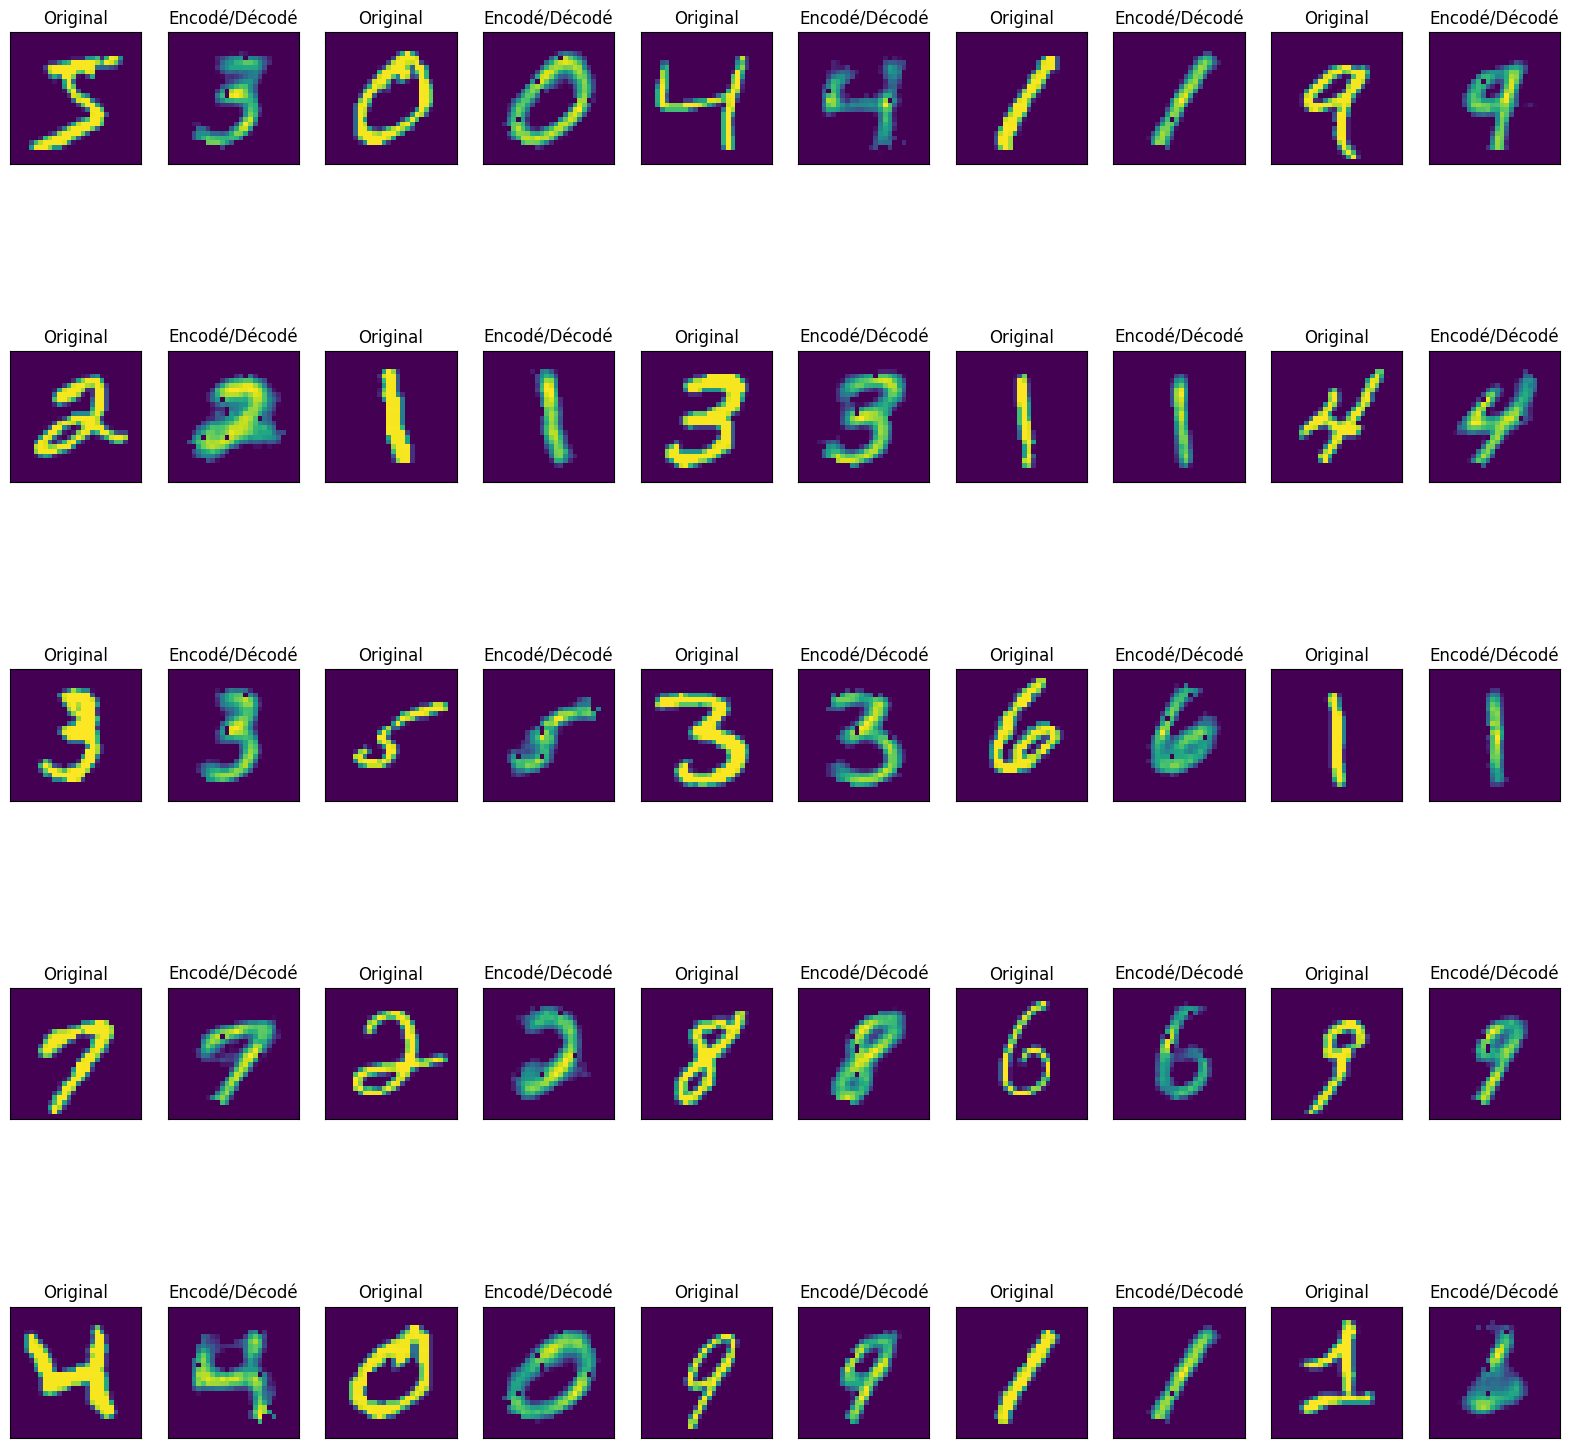

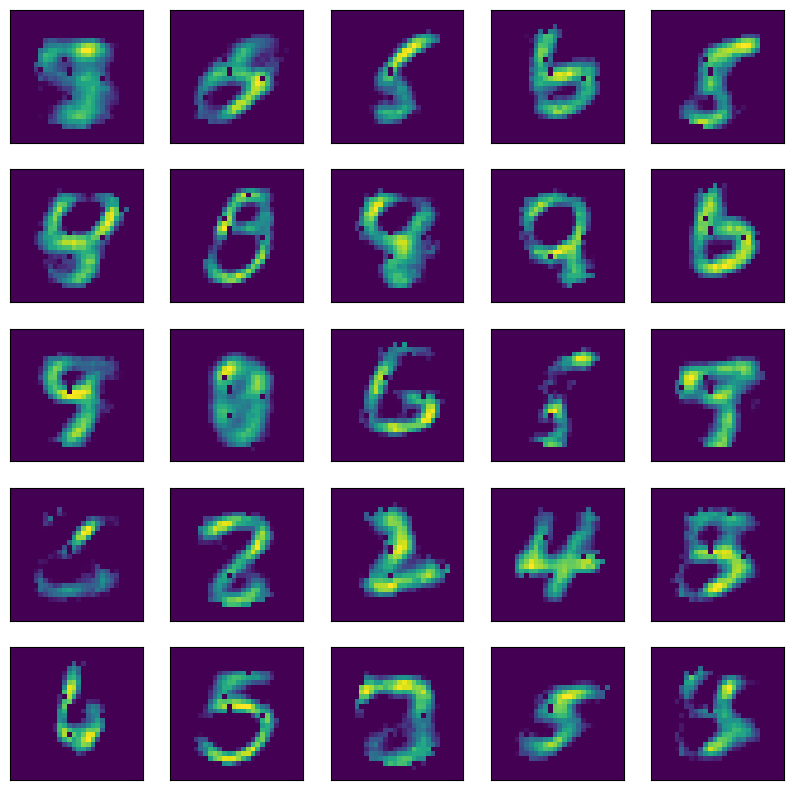

In [150]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,20)) # Augmentez la taille pour mieux visualiser les paires d'images

for i in range(25): # Affiche les 25 premières paires d'images
    # Affiche l'image originale
    plt.subplot(5,10,2*i+1) # 5 lignes, 10 colonnes, position impair pour l'original
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.title("Original")

    # Affiche l'image encodée et décodée
    plt.subplot(5,10,2*i+2) # 5 lignes, 10 colonnes, position pair pour l'encodé/décodé
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    decoded_images = model.decoder(model.encoder(tf.reshape(train_images[i],[1,28,28])))
    plt.imshow(decoded_images[0,0])
    plt.title("Encodé/Décodé")
plt.show()

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = model.decoder(tf.random.normal([1, latent_dim]))
    plt.imshow(img[0,0])
plt.show()


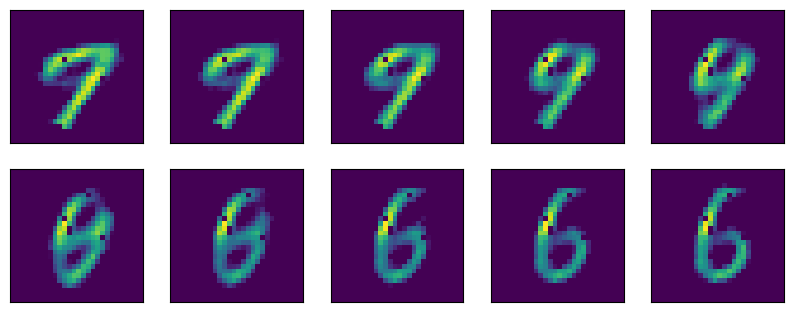

In [151]:
img0 = train_images[15]
img0_encoded = model.encoder(tf.reshape(img0, [1,28,28]))

img1 = train_images[18]
img1_encoded = model.encoder(tf.reshape(img1, [1,28,28]))

imgs = [model.decoder([(1-t)*img0_encoded + t*img1_encoded]) for t in np.linspace(0, 1, 10)]


plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = imgs[i]
    plt.imshow(img[0,0])
plt.show()